In [1]:
import sys, os
from Feature_engineering import *
from cleaning import * 
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
trainFile, testFile = "../data/corpus.tache1.learn.utf8", "../data/corpus.tache1.test.utf8"

In [32]:
train, test = load_data(trainFile, testFile)

Loading : train data
Loading : test data


In [33]:
dataClass = DataSet()
df = train#dataClass.lemmatisation()
df.fillna("", inplace = True)

In [19]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
class Classifier(BaseEstimator):

    def __init__(self):
        self.naiveBayes = MultinomialNB()
        pass

    def fit(self, X, y):

        # Check that X and y have correct shape
        # Return the classifier
        self.naiveBayes.fit(X, y)
        return self

    def predict(self, X):
        
        prediction = self.naiveBayes.predict(X)
        results = pd.DataFrame()
        results["prediction_raw"]= prediction
        #closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        results["prediction_1"] = 0
        for i, row in results.iterrows():
            results.at[i, "prediction_1"] = 1 if (results.loc[i-5: i+5, "prediction_raw"]).mean() >= 0.5 else 0
        results["prediction_2"] = 0
        for i , row in results.iterrows():
            results.at[i, "prediction_2"] = 1 if (results.loc[i-1: i+1, "prediction_1"]).mean() >= 0.5 else 0
        return results["prediction_2"].to_numpy()

In [17]:
df[df["label"] != 0]["label"].sum()

7523

In [38]:
clf = MultinomialNB()
count_vect = CountVectorizer(analyzer='word',lowercase = False ,ngram_range= (1,2))
count_vect.fit(df["text"])
train_count =  count_vect.transform(df["text"])
Scores = cross_val_score( clf, train_count, df["label"], cv=5, scoring=make_scorer(f1_score,pos_label=1))


In [39]:
Scores

array([0.50446067, 0.4836703 , 0.48953179, 0.49838969, 0.45797995])

# pos tag

In [5]:
df = train

In [6]:
clf = Classifier()
#data, label = df.loc[:, "ADJ":"SPACE"], df["label"]
#data = data.div(df["length"], axis=0)
count_vect = CountVectorizer(analyzer='word',lowercase = False ,ngram_range= (1,2), min_df = 10, max_df = 0.5)
count_vect.fit(df["text"])
train_count =  count_vect.transform(df["text"])
#cross_validate( clf, train_count, df["label"], cv=5, scoring=make_scorer(f1_score,pos_label=1))


In [7]:
clf.fit(train_count, df["label"])
pred = clf.predict(count_vect.transform(test["text"]))

In [191]:
coef = clf.naiveBayes.coef_
mostpositif = np.argsort(coef[0])[-10:]
[vocab_inverse[k] for k in mostpositif]

['pas', 'en', 'est', 'qui', 'des', 'que', 'les', 'le', 'et', 'la']

In [192]:
mostnegative =  np.argsort(coef[0])[:10]
[vocab_inverse[k] for k in mostnegative]

['000',
 'plus équilibré',
 'tout pour',
 'est évidemment',
 'aux évolutions',
 'plus sûr',
 'estime de',
 'poignée',
 'aux États',
 'plus sombres']

In [30]:
vocab = count_vect.vocabulary_
vocab_inverse = {v: k for k,v in vocab.items()}

In [93]:
probability_inverse= clf.naiveBayes.feature_log_prob_

In [145]:
prior = np.array([[clf.naiveBayes.class_log_prior_[0]],[clf.naiveBayes.class_log_prior_[1]]])
prior = np.repeat(prior, probability.shape[1], axis=1)
count = clf.naiveBayes.feature_count_
featureProba = np.log(count.sum(axis=0) / count.sum())
featureProba = np.repeat(np.array([featureProba]), 2, axis=0)


In [178]:
Probability = probability_inverse + prior - featureProba 

In [179]:
Probability[0][np.argsort(Probability[0])]#[-10:]]

array([-3.86442319, -3.72843419, -3.69643146, ...,  0.11245079,
        0.11245079,  0.11245079])

In [180]:
# J Chirac
#mot les plus frequents:
probs_1 = Probability[1][np.argsort(Probability[1])[-10:]]
words_indices_1 = np.argsort(Probability[1])[-10:]
words_1 = np.array([vocab_inverse[k] for k in words_indices_1])
probs_0 = Probability[0][np.argsort(Probability[0])[-10:]]
words_indices_0 = np.argsort(Probability[0])[-10:]
words_0 = np.array([vocab_inverse[k] for k in words_indices_0])

In [181]:
best_words = np.vstack((words_1, words_0)).transpose()

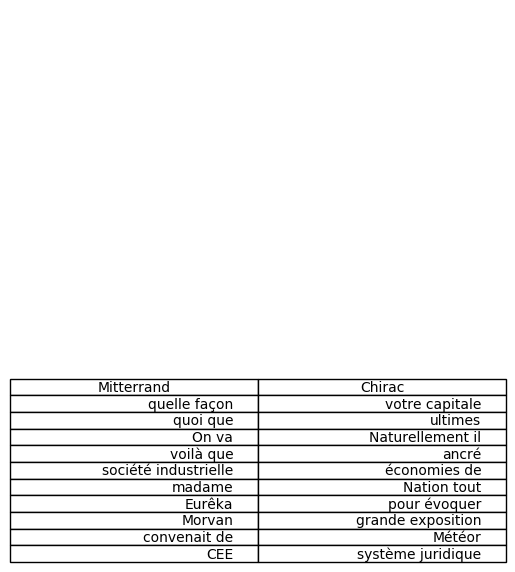

In [182]:
fig, ax = plt.subplots()
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

the_table = plt.table(cellText=best_words,
                      colLabels=["Mitterrand", "Chirac"],
                      loc='bottom')

plt.show()
#plt.rcdefaults()
#plt.xticks(rotation='vertical')
#plt.bar(words, probs)

In [35]:
probs = probability[0][np.argsort(probability[0])[-10:]]
words_indices = np.argsort(probability[0])[-10:]
words = [vocab_inverse[k] for k in words_indices]
words

['un', 'que', 'qui', 'en', 'est', 'des', 'le', 'les', 'et', 'la']

<BarContainer object of 10 artists>

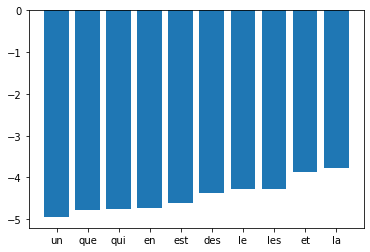

In [36]:
plt.bar(words, probs)

In [56]:
test["label"] = pred

In [58]:
test[test["label"] == 1]

,text,label
173,J'y ai constaté l'effort des exploitants qui s...,1
174,Ils ont su adapter leur production aux contrai...,1
175,"Je ne m'attarderai pas sur ce problème, mais j...",1
176,"Comme vous savez, après avoir été visité cette...",1
177,J'y ai rencontré les organisations régionales ...,1
...,...,...
26102,Il a fallu d'abord fonder les réconciliations ...,1
26103,"La réconciliation franco-allemande, pour ne pa...",1
26104,Aujourd'hui on doit penser que les réconciliat...,1
26105,Mais l'Europe en dépit des obstacles qu'elle r...,1


In [60]:
file = open("prediction", "w")
for i in pred:
    if i ==1:
        file.write("M\n")
    else:
        file.write("C\n")
file.close()

In [47]:
from sklearn.metrics import f1_score
#(pred==test["label"])
f1_score(test["label"], pred, pos_label=1)

0.7083716651333948

In [10]:
ScoresNaive = label.mean()

In [11]:
ScoresNaive

0.13103304129726717

In [2]:
Scores_raw, Scores_stemmed, Scores_lemmed, Scores_SW_raw, Scores_SW_lemmed, Scores_SW_stemmed= 0.761954961491559,0.7363605089460419,0.7563927356254625,0.47164415846000407,0.4492001019200389,0.4492001019200389

Text(0.5, 1.0, 'Scores F1 avec post-traitement')

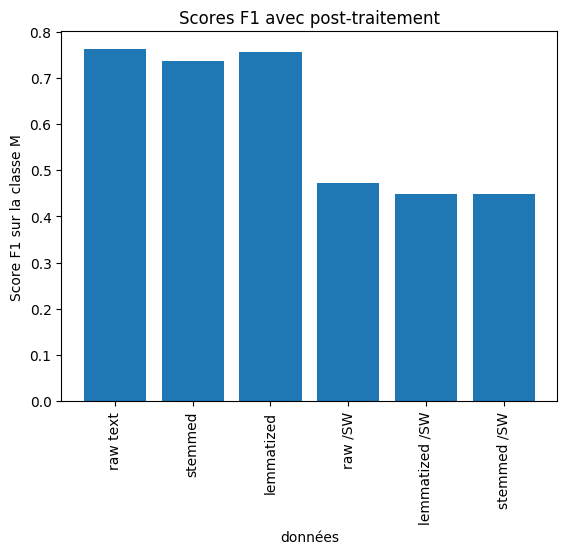

In [4]:
plt.rcdefaults()
plt.xticks(rotation='vertical')
plt.bar(["raw text", "stemmed", "lemmatized", "raw /SW", "lemmatized /SW", "stemmed /SW"], [Scores_raw, Scores_stemmed, Scores_lemmed, Scores_SW_raw, Scores_SW_lemmed, Scores_SW_stemmed])
plt.ylabel("Score F1 sur la classe M")
plt.xlabel("données")
plt.title("Scores F1 avec post-traitement")
